In [1]:
import sys
sys.path.append('../')

In [2]:
%matplotlib inline

from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from water import data

sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(13, 9), 'figure.max_open_warning': 50})
sns.set_context('talk')

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [3]:
df = data.load()

In [4]:
def filter_year(df, yr):
    return (df.index >= str(yr)) & (df.index < str(yr + 1))

def plot_year(df, yr, site, ax=None, xlim=None):
    x = df.loc[filter_year(df, yr), site].dropna()
    if ax is None:
        _, ax = plt.subplots(1)
    ax.set_yscale('log')
    if not x.size:
        return
    ax.plot([x.index[0], x.index[-1]], [1000, 1000], 'k--', alpha=0.3) # threshold
    ax.plot(x.index, x.values, '-o')
    if xlim is not None:
        ax.set_xlim(xlim)

def plot_all_years_site(df, site):
    years = list(range(2010, 2019))
    f, axs = plt.subplots(len(years), sharey=True, figsize=(14, 12))
    axs[0].set_title(' '.join(site.split('_')).title())
    for i, yr in enumerate(years):
        plot_year(df, yr, site, axs[i], xlim=[datetime(yr, 5, 20), datetime(yr, 9, 10)])
        axs[i].set_ylabel(yr)

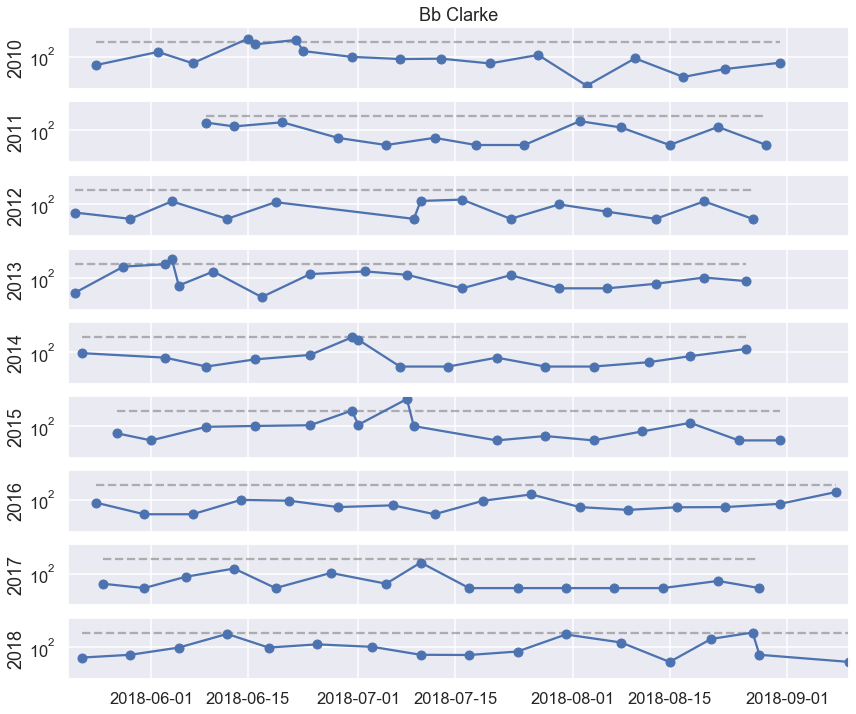

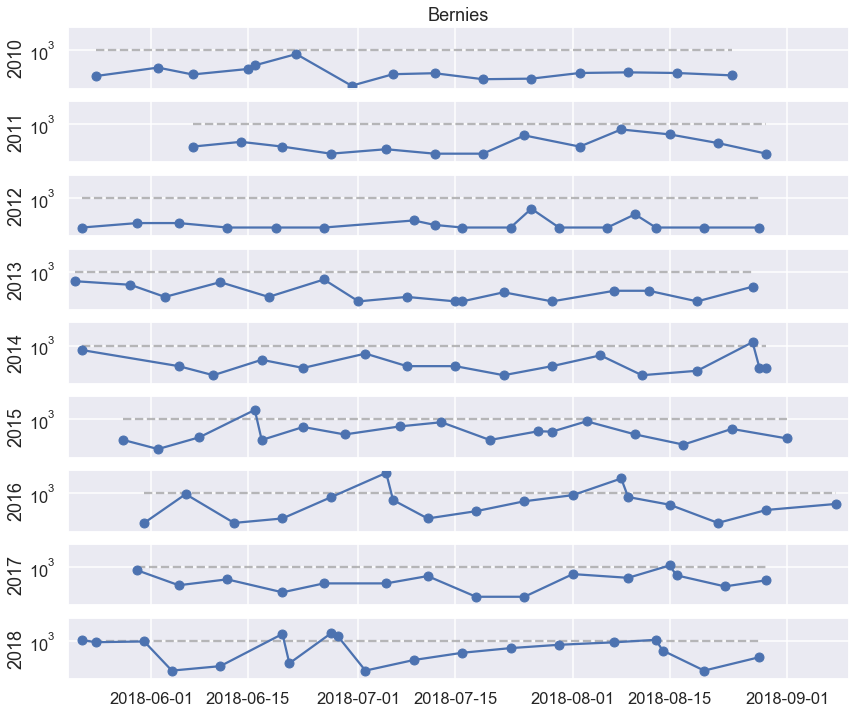

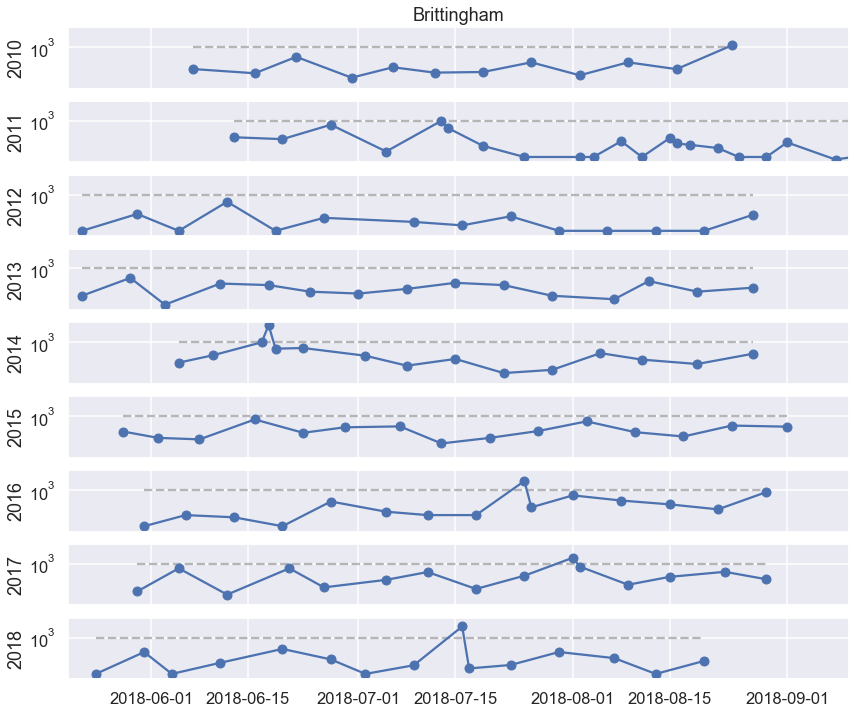

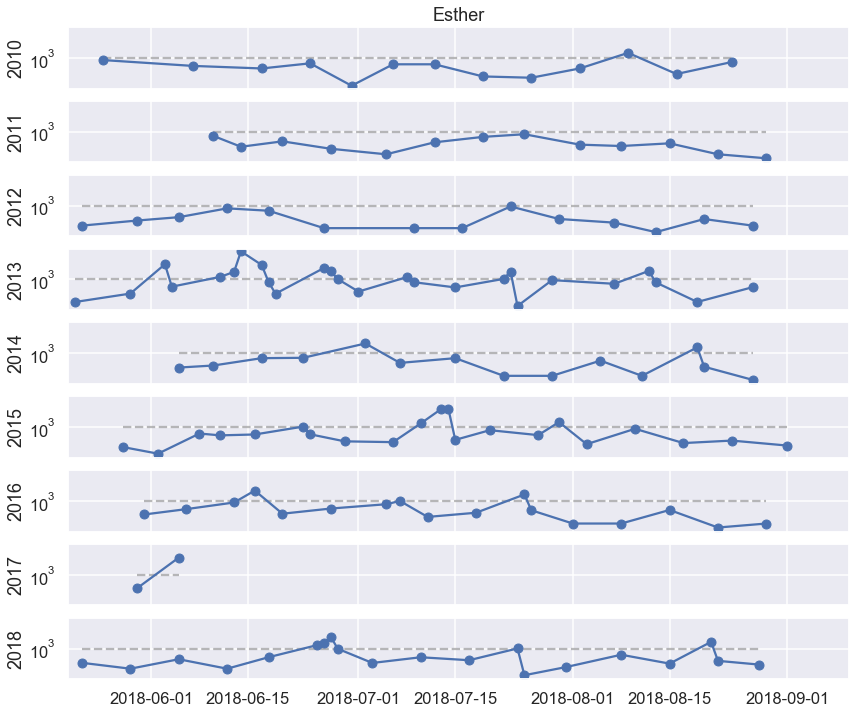

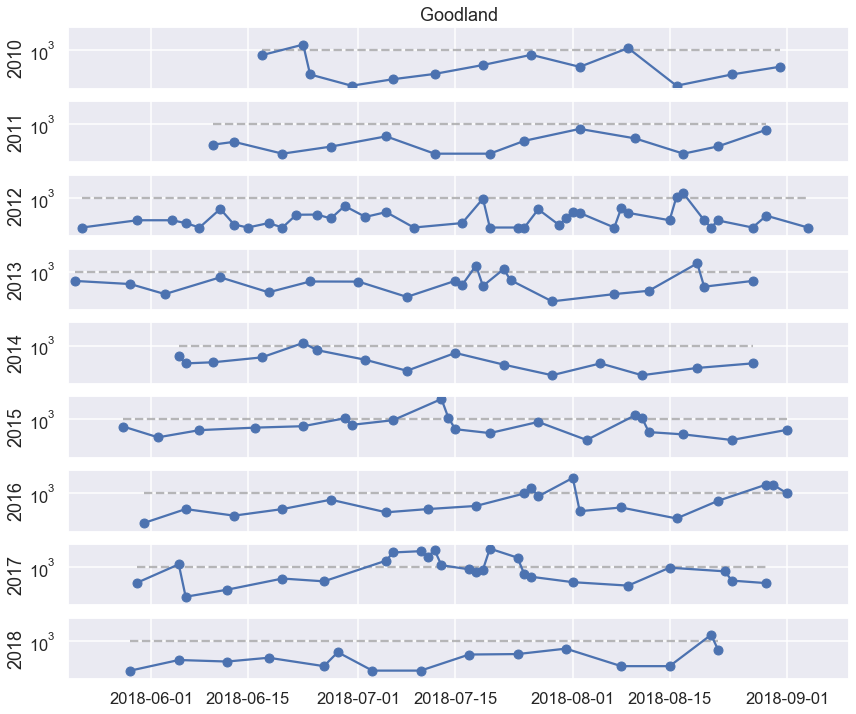

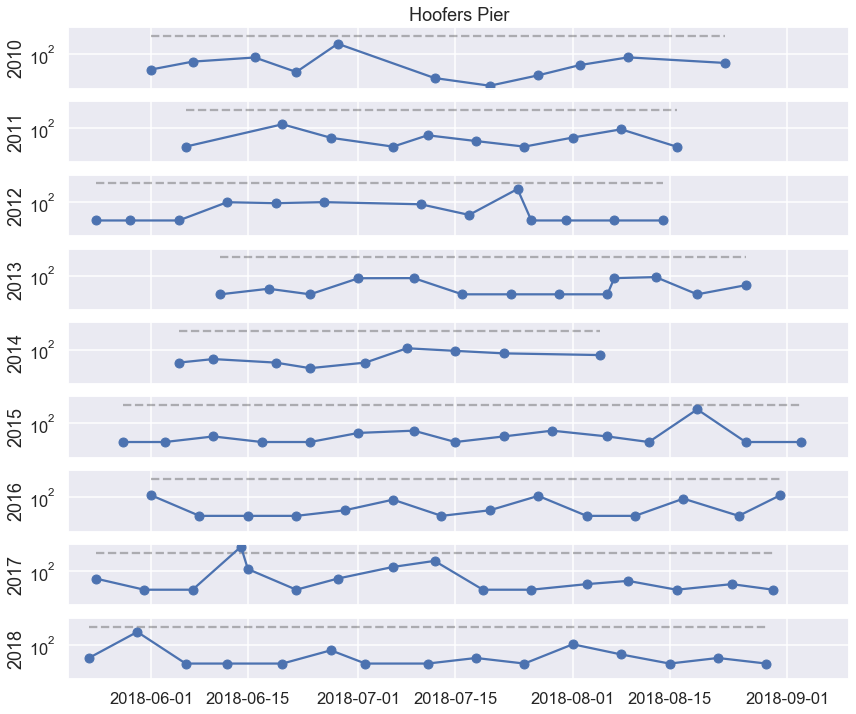

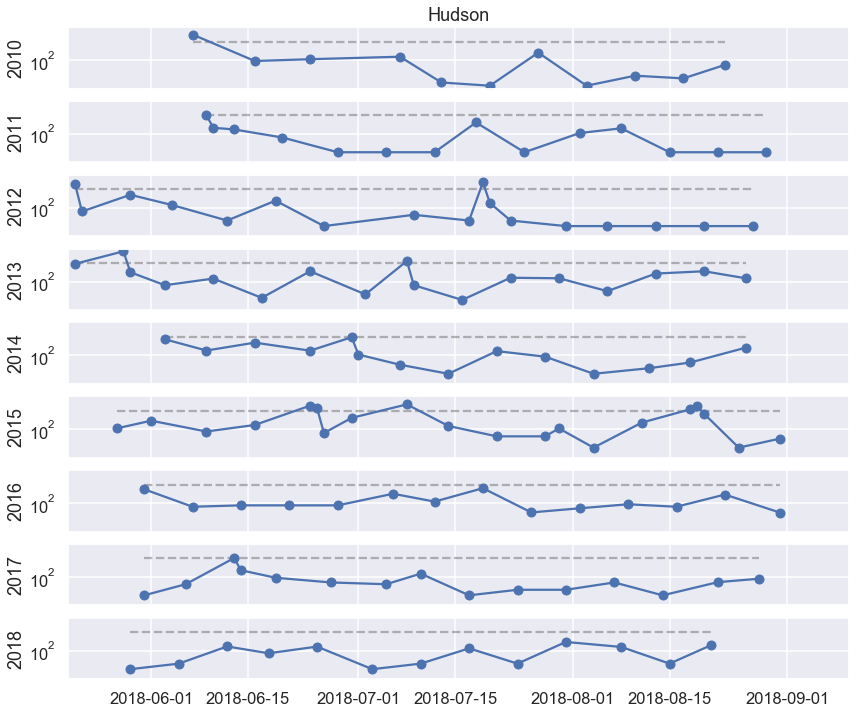

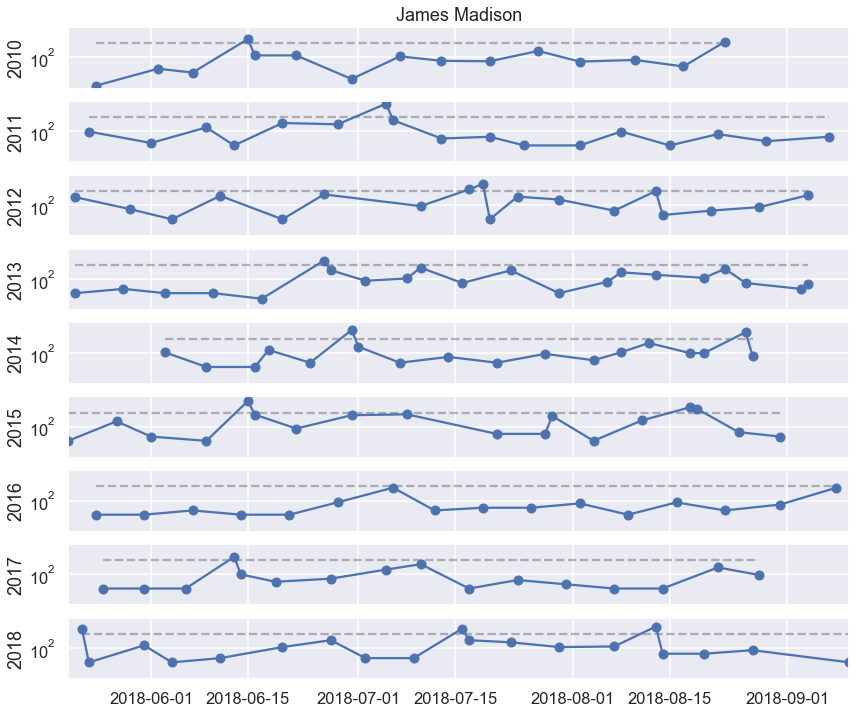

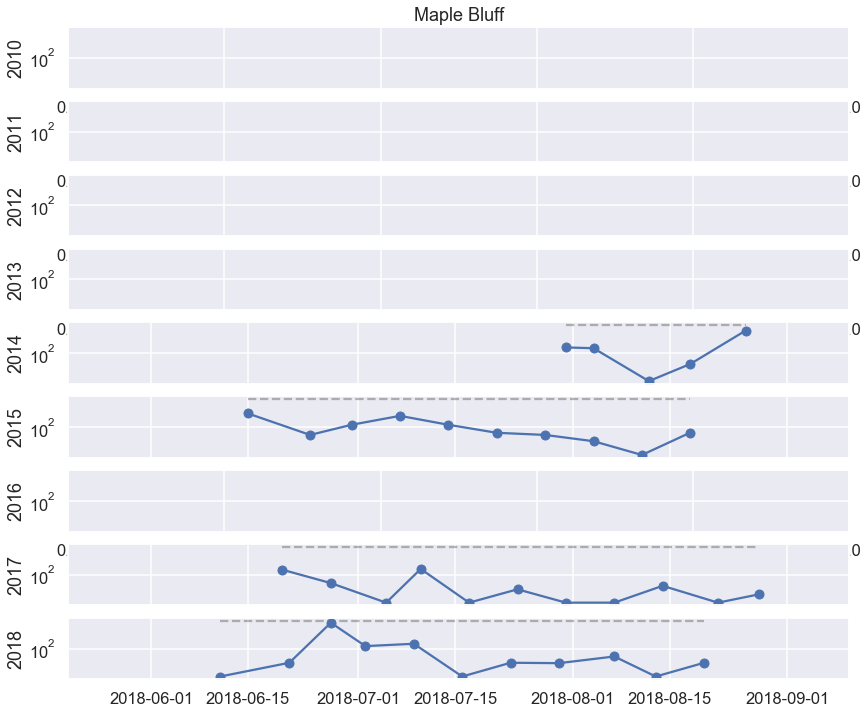

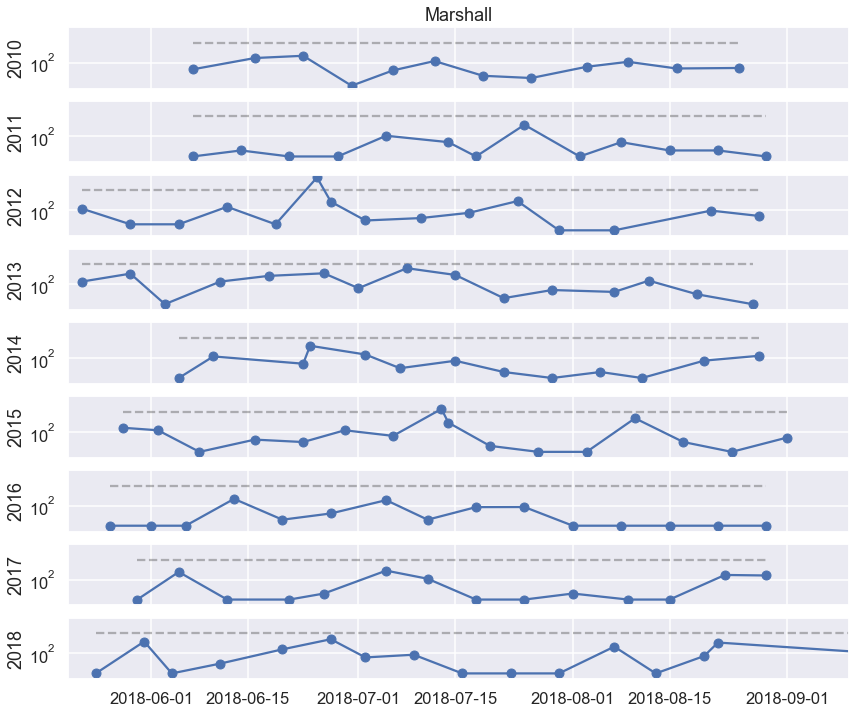

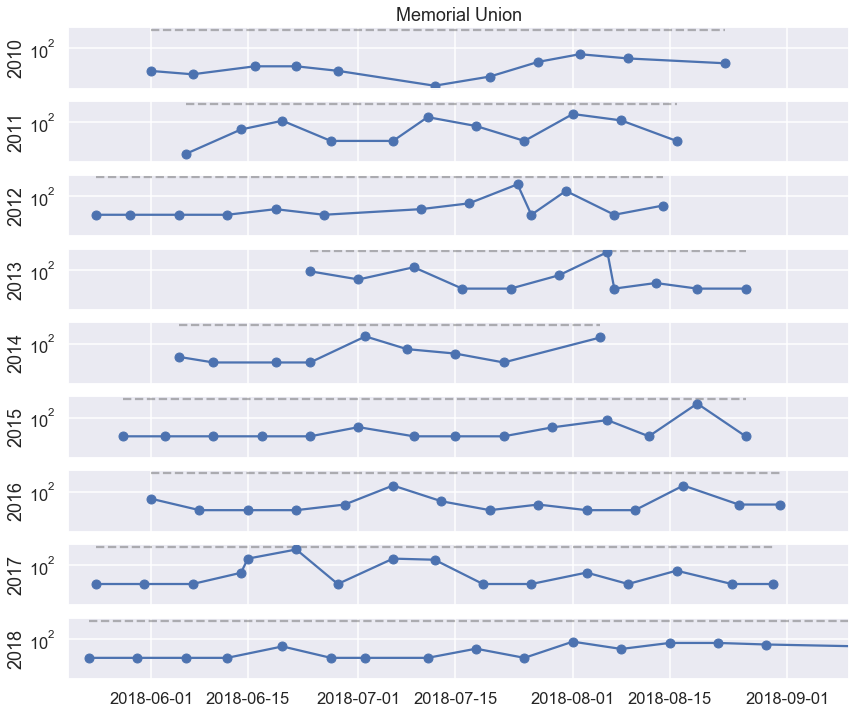

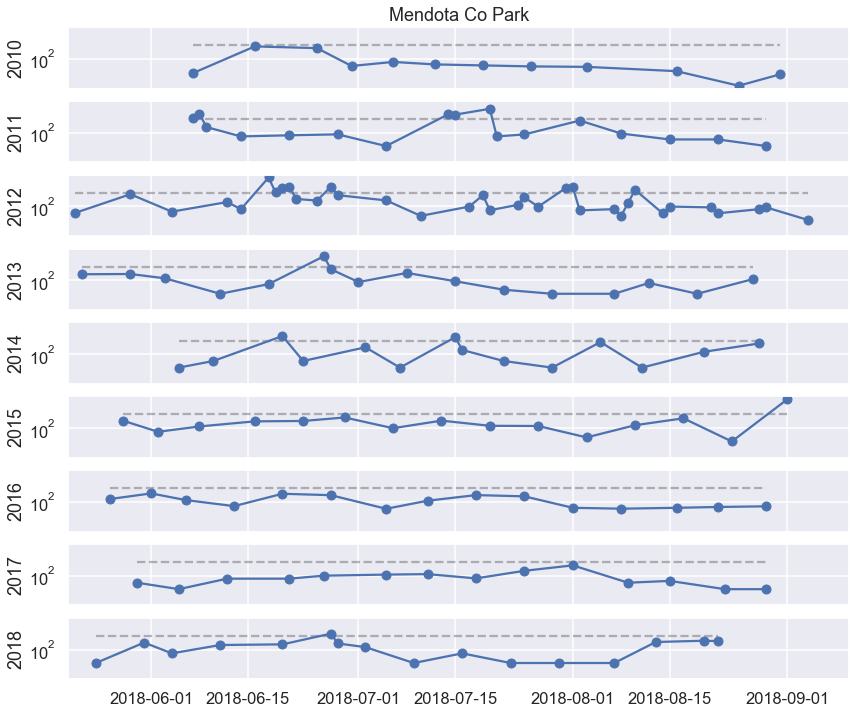

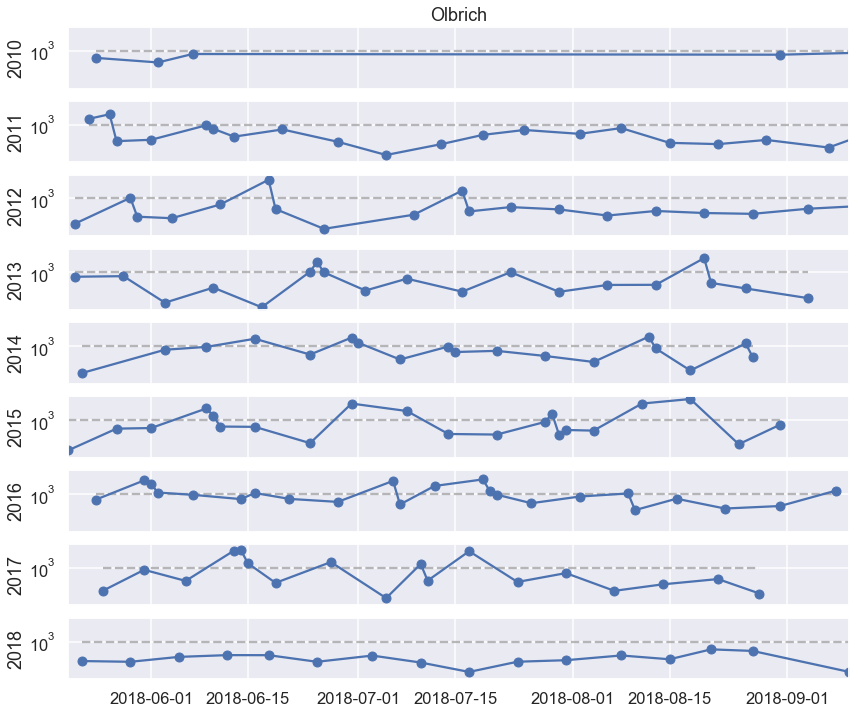

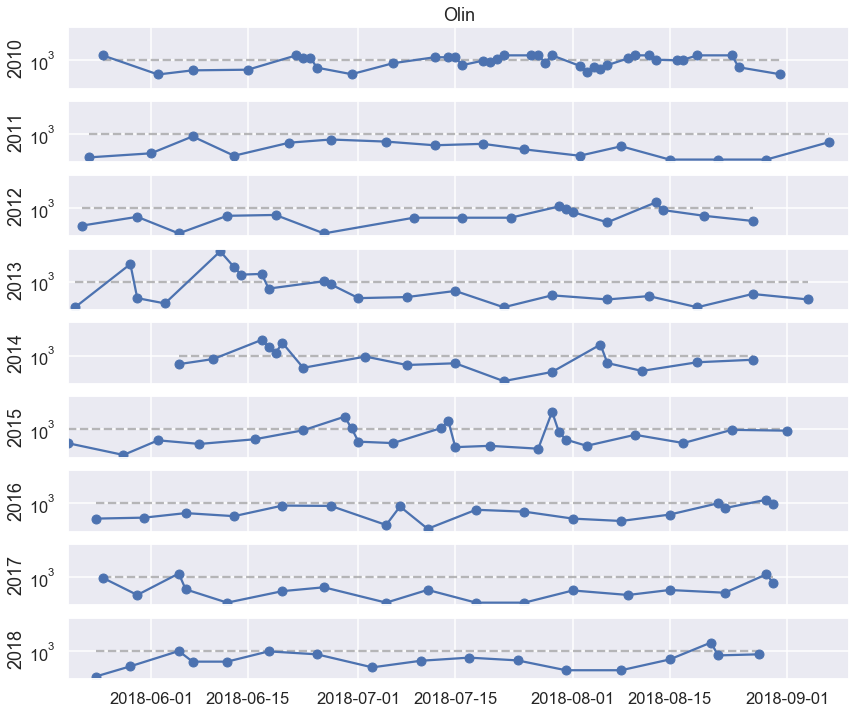

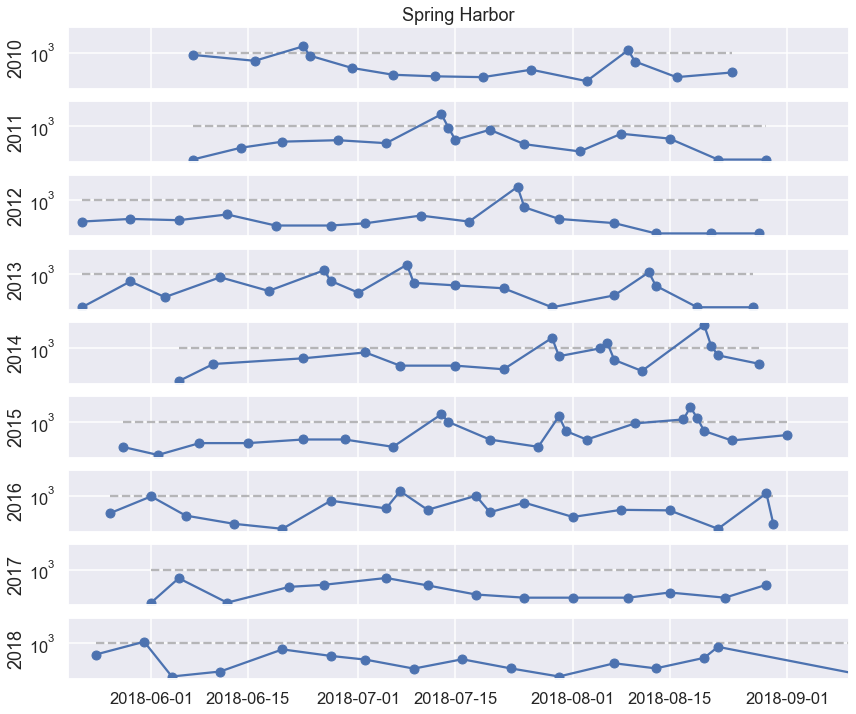

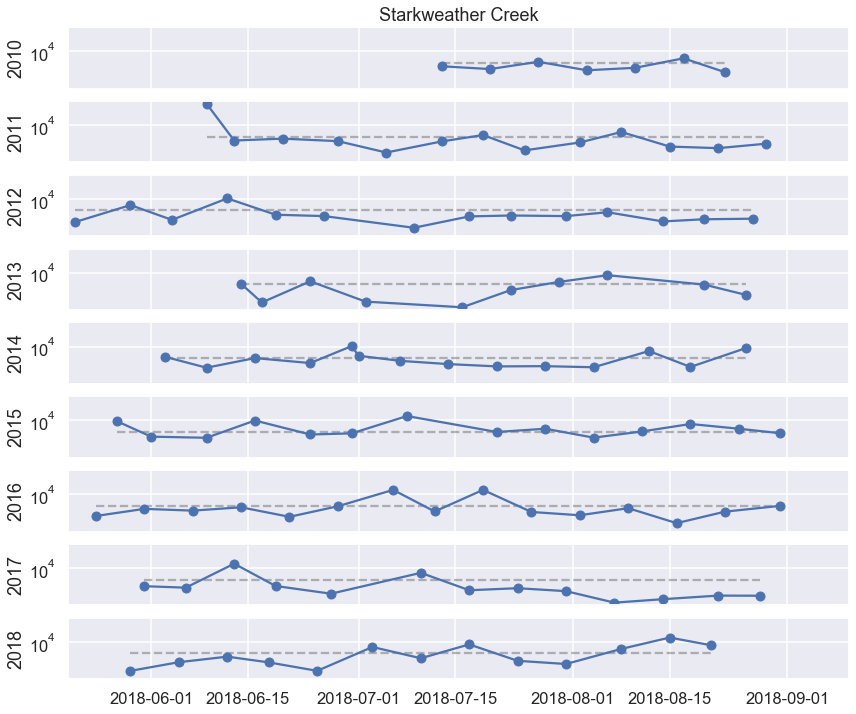

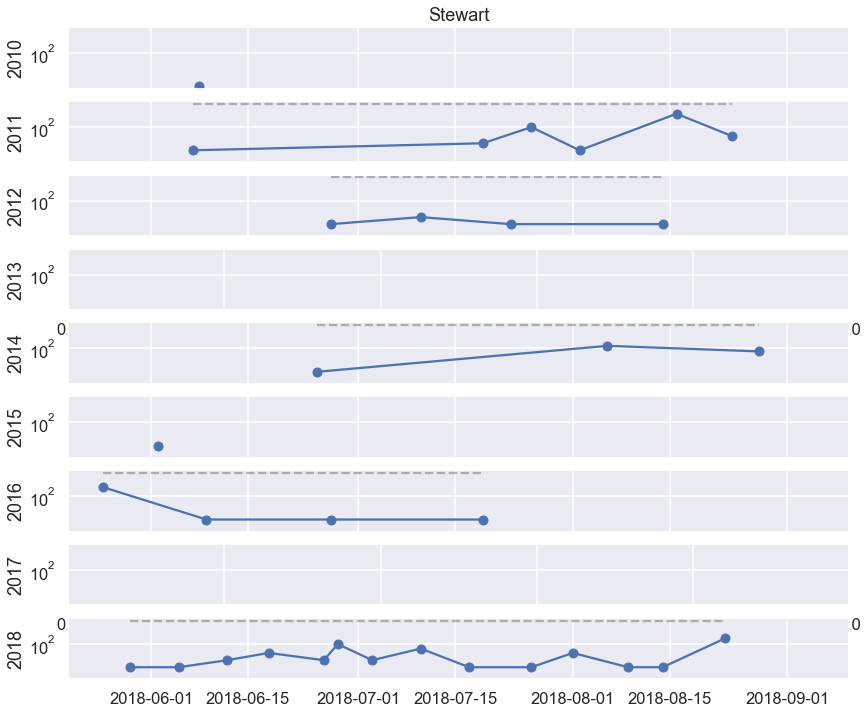

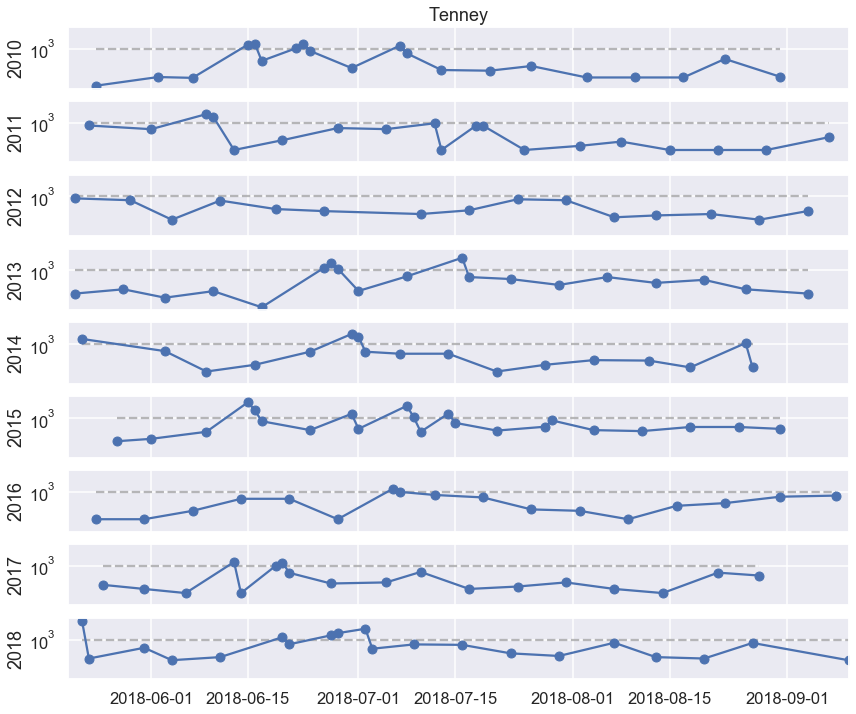

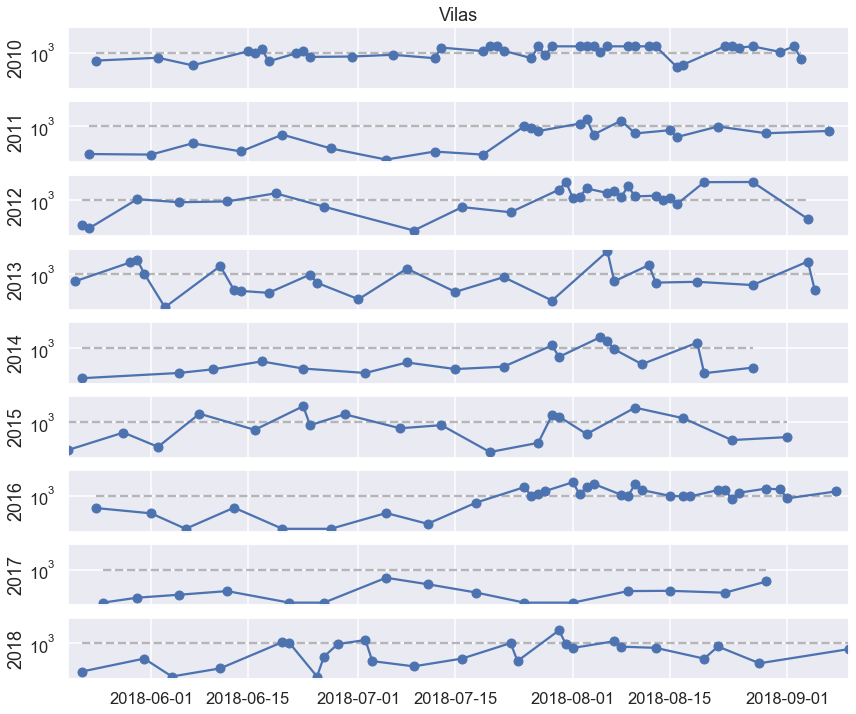

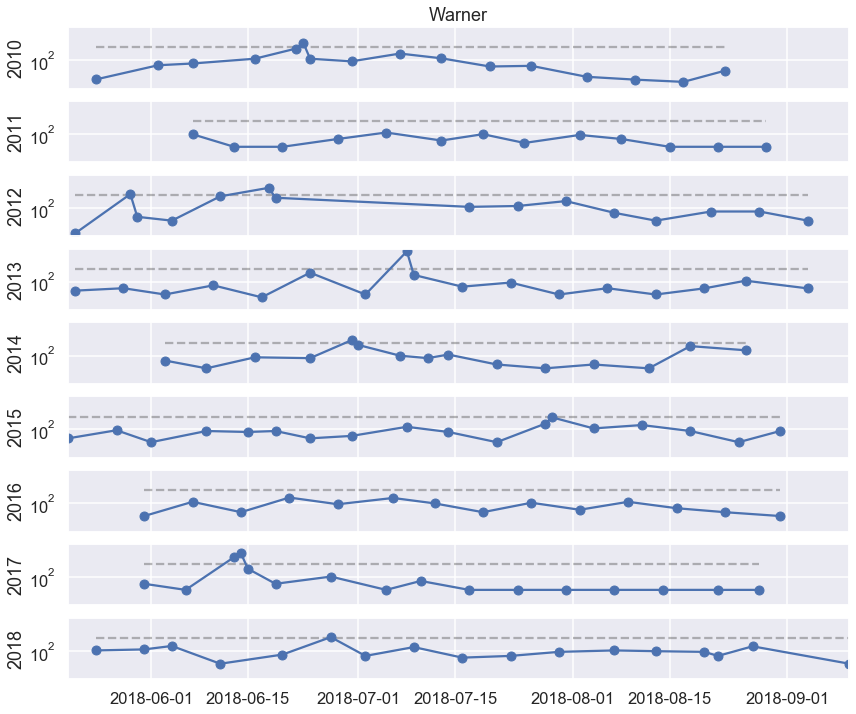

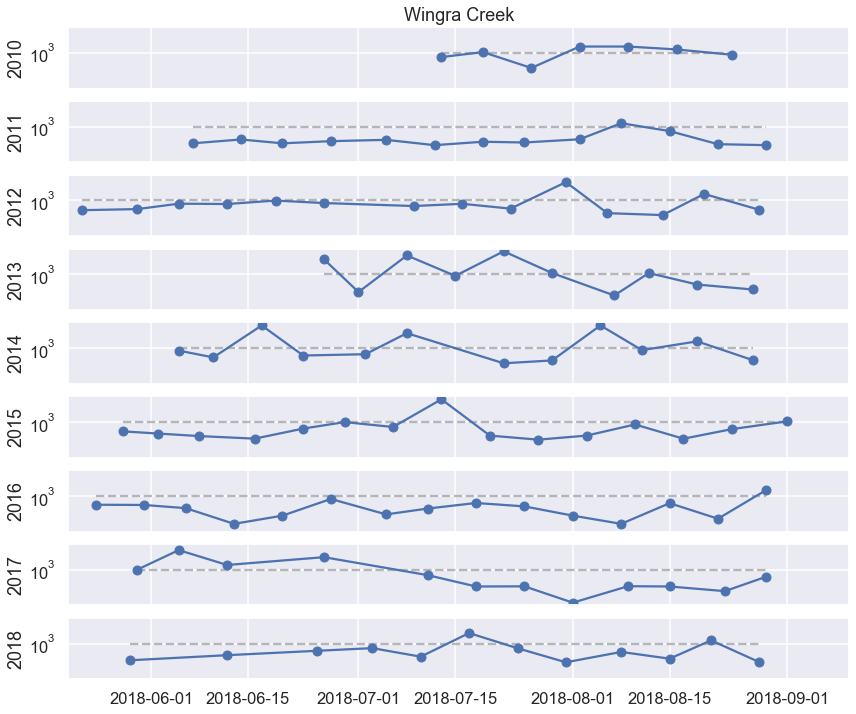

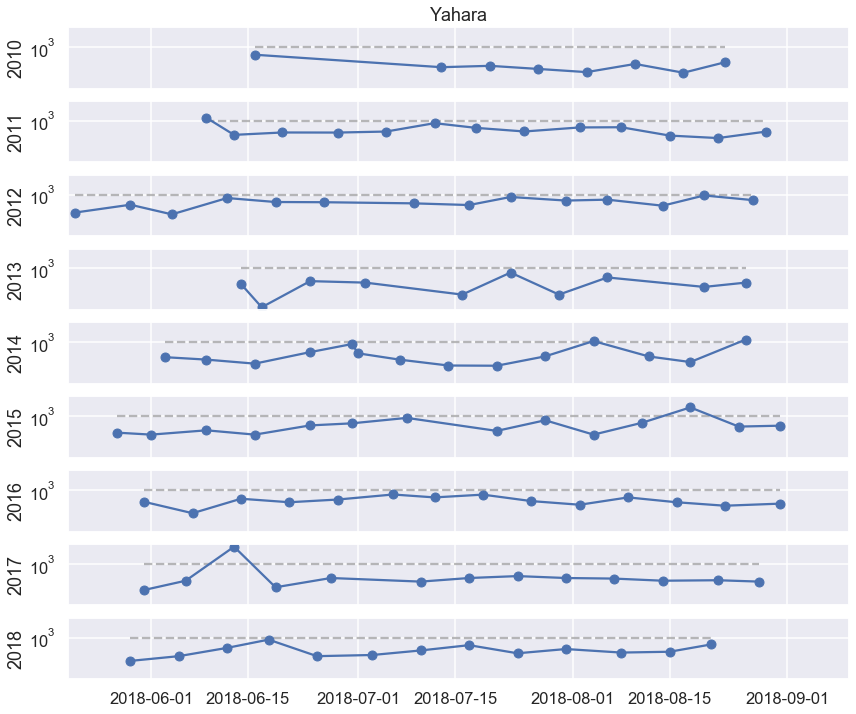

In [5]:
for site in df.columns:
    if df[site].notna().sum() > 30:
        plot_all_years_site(df, site)